
# Assignment: Linear Regression, Logistic Regression, and K-Means (From Scratch)

**Instructions**
- You are NOT allowed to use `scikit-learn` for model implementation, scaling.
- You may use it for implementation of clustering
- You may use: `numpy`, `matplotlib`, and standard Python libraries only.
- Every step (scaling, loss, gradients, optimization) must be implemented manually.
- Clearly comment your code and explain your reasoning in Markdown cells.

We will need to first create synthetic data for the models to rtain and and to further test them to find the accuracy.

In [33]:
import numpy as np

def generate_linear_data(n_samples=100,
                         n_features=1,
                         noise=1.0,
                         bias=0.0,
                         coef=None,
                         random_state=None):
    
    rng = np.random.RandomState(random_state)
    if coef is None:
        coef = rng.randn(n_features)
    else:
        coef = np.asarray(coef, dtype=float)
        if coef.ndim == 0:
            coef = np.repeat(float(coef), n_features)
        elif coef.shape[0] != n_features:
            raise ValueError("coef length must equal n_features")

    X = rng.randn(n_samples, n_features)
    y = X.dot(coef) + bias + rng.randn(n_samples) * noise
    return X, y, coef, bias

def train_test_split(X, y, test_size=0.2, random_state=None):
    n = X.shape[0]
    rng = np.random.RandomState(random_state)
    idx = np.arange(n)
    rng.shuffle(idx)
    split = int(n * (1 - test_size))
    tr, te = idx[:split], idx[split:]
    return X[tr], X[te], y[tr], y[te]




## Question 1: Linear Regression from Scratch (with Standardization and Regularization)

You are given a dataset `(X, y)`.

### Tasks
1. Implement **StandardScaler manually**:
   - Compute mean and standard deviation for each feature.
   - Standardize the features.
2. Implement **Linear Regression using Gradient Descent**.
3. Add **L2 Regularization (Ridge Regression)**.
4. Plot:
   - Loss vs iterations
   - True vs predicted values

Do NOT use `sklearn`.


In [34]:

import numpy as np
import matplotlib.pyplot as plt


In [35]:
# Implement StandardScaler manually ,  first read about it, how it works and then implement it 
class StandardScalerManual:

    def fit(self, X):
        self.no_of_features = X.shape[1]
        self.mean = np.array(self.no_of_features * [0.0])
        self.standard_deviation = np.array(self.no_of_features * [0.0])

        for i in range(self.no_of_features):
            self.mean[i] = np.mean(X[:, i])
            self.standard_deviation[i] = 1 if np.std(X[:, i]) == 0 else np.std(X[:, i])
        pass
    
    def transform(self, X):
        copy_X = X.copy()
        
        for i in range(self.no_of_features):
            copy_X[:, i] = (X[:, i] - self.mean[i]) / self.standard_deviation[i]

        return copy_X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [36]:
import numpy as np
import matplotlib.pyplot as plt

class LinearRegressionManual:
    def __init__(self, lr=0.01, epochs=1000, l2_lambda=0.0, l1_lambda=0.0):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.l2_lambda = float(l2_lambda)
        self.l1_lambda = float(l1_lambda)

        self.coef = None        
        self.bias = None

        self.loss_history = []
        self.score_history = []

    def _prepare_arrays(self, X, y=None):
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if y is not None:
            y = np.asarray(y, dtype=float).ravel()
            if X.shape[0] != y.shape[0]:
                raise ValueError("X and y have different number of samples")
            return X, y
        return X

    def fit(self, X, y):
        X, y = self._prepare_arrays(X, y)
        n, m = X.shape

        self.coef = np.zeros(m, dtype=float)
        self.bias = 0.0
        self.loss_history = []
        self.score_history = []

        for epoch in range(self.epochs):
            y_pred = X.dot(self.coef) + self.bias  
            error = y_pred - y  

            # gradients computation
            grad_w = (2.0 / n) * (X.T.dot(error))  
            grad_b = (2.0 / n) * np.sum(error)

            
            if self.l2_lambda != 0.0:
                grad_w = grad_w + 2.0 * self.l2_lambda * self.coef

            # gradient step for weights and bias
            self.coef = self.coef - self.lr * grad_w
            self.bias = self.bias - self.lr * grad_b

            # L1 regularization 
            if self.l1_lambda != 0.0:
                self.coef = np.sign(self.coef) * np.maximum(0.0, np.abs(self.coef) - self.lr * self.l1_lambda)

            # compute loss & score
            y_pred_new = X.dot(self.coef) + self.bias
            err_new = y_pred_new - y
            mse = np.mean(err_new ** 2)

            reg_l2 = self.l2_lambda * np.sum(self.coef ** 2) if self.l2_lambda != 0.0 else 0.0
            reg_l1 = self.l1_lambda * np.sum(np.abs(self.coef)) if self.l1_lambda != 0.0 else 0.0

            loss = mse + reg_l2 + reg_l1
            self.loss_history.append(loss)

            # R^2 score
            ss_total = np.sum((y - np.mean(y)) ** 2)
            if ss_total == 0.0:
                r2 = 0.0
            else:
                ss_res = np.sum((y - y_pred_new) ** 2)
                r2 = 1.0 - (ss_res / ss_total)
            self.score_history.append(r2)

        return self

    def predict(self, X):
        X_prepared = self._prepare_arrays(X)
        # _prepare_arrays returns X or (X, y), so handle tuple
        if isinstance(X_prepared, tuple):
            X = X_prepared[0]
        else:
            X = X_prepared
        if self.coef is None:
            raise ValueError("Model not fitted. Call fit(X,y) first.")
        return X.dot(self.coef) + self.bias

    def plotting_loss_and_score(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 3, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.score_history, label='R^2 Score', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('R^2 Score')
        plt.title('R^2 Score over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()


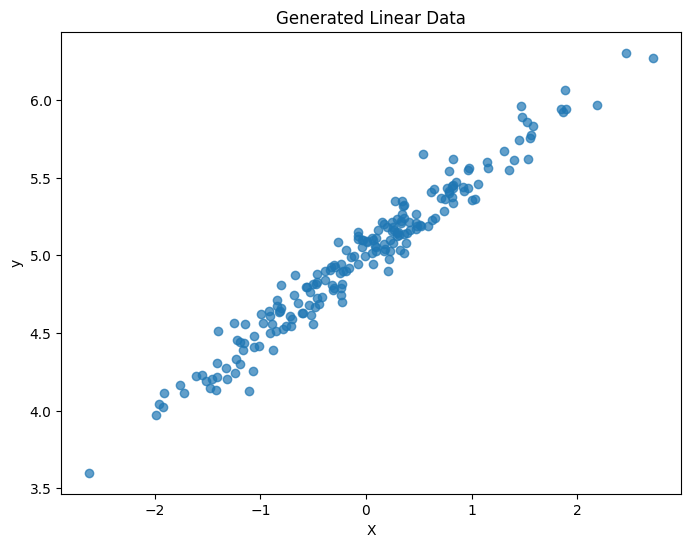

True coef: [0.49671415] bias: 5.0
Learned coef: [0.47622824] bias: 4.995144203202276


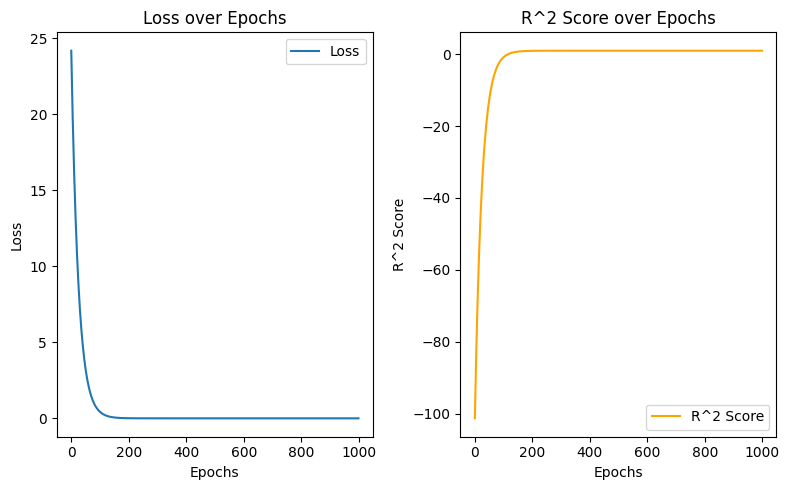

Comparing R2 scores:
R2 start: -101.34339338593004
R2 final: 0.9594897024614555


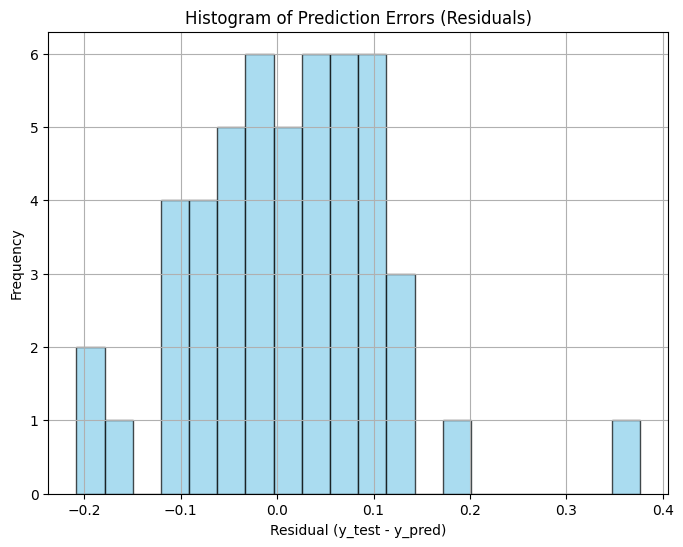

Comparing residual statistics:
test residual mean, std: 0.013554333296291663 0.10070222424040133
test MSE: 0.010324657918071037


In [37]:
# Generate synthetic linear data
X, y, true_coef, true_bias = generate_linear_data(n_samples=200,
                                                    n_features=1,
                                                    noise= 0.1,
                                                    bias=5.0,
                                                    random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.7)
plt.xlabel('X')
plt.ylabel('y') 
plt.title('Generated Linear Data')
plt.show()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScalerManual()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
model = LinearRegressionManual(lr=0.01, epochs=1000, l2_lambda=0.0, l1_lambda=0.0)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Print results
print("True coef:", true_coef, "bias:", true_bias)
print("Learned coef:", model.coef, "bias:", model.bias)

# Plot loss and score history
model.plotting_loss_and_score()

# Print start and final R^2 scores
print("Comparing R2 scores:")
print("R2 start:", model.score_history[0])
print("R2 final:", model.score_history[-1])

# Compare predicted vs actual residual statistics
res = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.hist(res, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Residual (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors (Residuals)')
plt.grid(True)
plt.show()

print("Comparing residual statistics:")
print("test residual mean, std:", np.mean(res), np.std(res))
print("test MSE:", np.mean(res**2))


## Question 2: Logistic Regression from Scratch (with Standardization and Regularization)

You are given a binary classification dataset.

### Tasks
1. Reuse your **manual StandardScaler**.
2. Implement **Logistic Regression using Gradient Descent**.
3. Use:
   - Sigmoid function
   - Binary Cross Entropy loss
4. Add **L2 Regularization**.
5. Report:
   - Training loss curve
   - Final accuracy

Do NOT use `sklearn`.


In [38]:
#Implement sigmoid function as told in the lectures 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [40]:

#Implement Logistic Regression from scratch and here also add the regularizaation term 
class LogisticRegressionManual:
    
    def __init__(self, lr=0.1, epochs=1000, l2_lambda=0.0, fit_intercept=True):
        self.lr = lr
        self.epochs = epochs
        self.l2_lambda = float(l2_lambda)
        self.fit_intercept = fit_intercept

        self.scaler = StandardScalerManual()
        self.w = None
        self.b = 0.0
        self.loss_history = []

    def loss(self, y_true, p_pred):
        n = y_true.shape[0]
        eps = 1e-12
        p = np.clip(p_pred, eps, 1 - eps)
        bce = -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
        l2_term = (self.l2_lambda / (2 * n)) * np.sum(self.w ** 2) if self.w is not None else 0.0
        return bce + l2_term

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        n_samples, n_features = X.shape

        # scale features
        X_scaled = self.scaler.fit_transform(X)

        # initialize weights & bias
        self.w = np.zeros(n_features, dtype=float)
        self.b = 0.0
        self.loss_history = []

        for epoch in range(1, self.epochs + 1):
            # linear model
            logits = X_scaled.dot(self.w) + self.b
            probs = sigmoid(logits)

            # loss for monitoring
            loss = self.loss(y, probs)
            self.loss_history.append(loss)

            # gradients
            error = probs - y  
            dw = (X_scaled.T.dot(error)) / n_samples
            db = np.mean(error)

            # add L2 gradient (exclude bias)
            if self.l2_lambda != 0.0:
                dw += (self.l2_lambda / n_samples) * self.w

            # update
            self.w -= self.lr * dw
            self.b -= self.lr * db


        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        if self.w is None:
            raise RuntimeError("Model is not fitted yet. Call fit first.")
        X_scaled = self.scaler.transform(X)
        logits = X_scaled.dot(self.w) + self.b
        return sigmoid(logits)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def score(self, X, y):
        y = np.asarray(y, dtype=int).reshape(-1)
        preds = self.predict(X)
        return np.mean(preds == y)


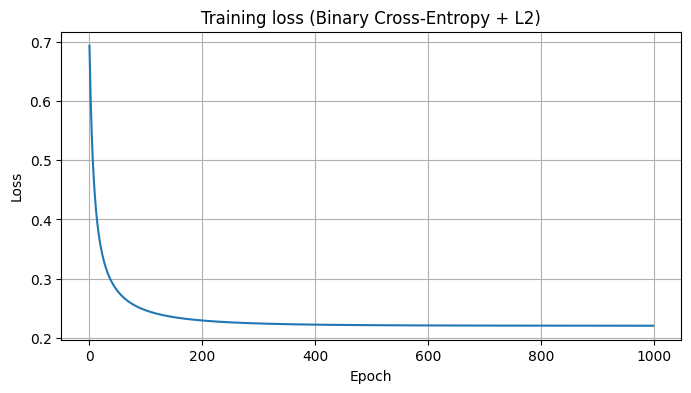

Final training accuracy: 0.9250
Final test accuracy:     0.9062


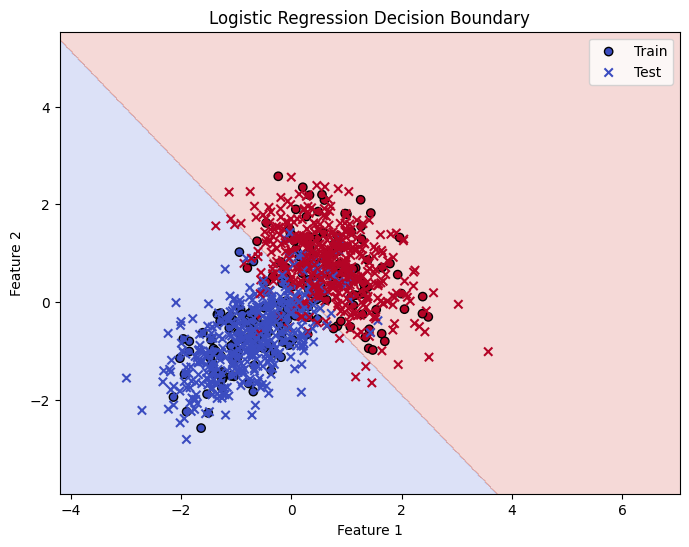

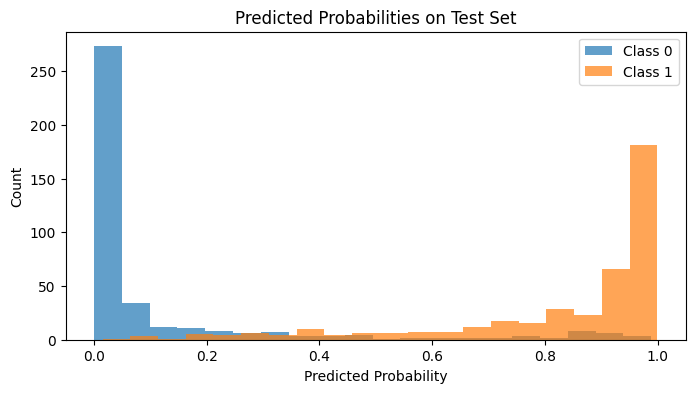

In [47]:
n = 1000
n_per_class = n // 2

mean0 = [0.0, 0.0]
cov0 = [[1.0, 0.6], [0.6, 1.0]]

mean1 = [2.0, 2.0]
cov1 = [[1.0, -0.4], [-0.4, 1.0]]

X0 = np.random.multivariate_normal(mean0, cov0, n_per_class)
X1 = np.random.multivariate_normal(mean1, cov1, n_per_class)

X = np.vstack([X0, X1])
y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])

# shuffle and split into train/test
perm = np.random.permutation(n)
X = X[perm]
y = y[perm]

split = int(0.2 * n)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# create scaler and scale features
scaler = StandardScalerManual()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create and fit model
model = LogisticRegressionManual(lr=0.2, epochs=1000, l2_lambda=0.1)
model.fit(X_train, y_train)

# training loss curve
plt.figure(figsize=(8, 4))
plt.plot(model.loss_history)
plt.title("Training loss (Binary Cross-Entropy + L2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# final accuracies
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Final training accuracy: {train_acc:.4f}")
print(f"Final test accuracy:     {test_acc:.4f}")

# Plot decision boundary and data points
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap="coolwarm")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", edgecolors='k', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", marker='x', label='Test')
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Plot predicted probabilities on test set
probs_test = model.predict_proba(X_test)
plt.figure(figsize=(8, 4))
plt.hist(probs_test[y_test == 0], bins=20, alpha=0.7, label='Class 0')
plt.hist(probs_test[y_test == 1], bins=20, alpha=0.7, label='Class 1')
plt.title("Predicted Probabilities on Test Set")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()



## Question 3: K-Means Clustering from Scratch (Matrix Clustering)

You are given a **random matrix** `M` of shape `(n, m)`.

### Tasks
Implement K-Means clustering **from scratch** such that:

1. Input:
   - A random matrix `M`
   - Number of clusters `k`
2. Output:
   - `assignment_table`: a matrix of same shape as `M`, where each element stores the **cluster label**
   - `cookbook`: a dictionary (hashmap) where:
     - Key = cluster index
     - Value = list of **positions (i, j)** belonging to that cluster
   - `centroids`: array storing centroid values

You must cluster **individual elements**, not rows.


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_matrix(M, k):
    n, m = M.shape
    X = M.reshape(-1, 1)

    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(X)

    assignment_table = labels.reshape(n, m)

    cookbook = {i: [] for i in range(k)}
    for idx, c in enumerate(labels):
        cookbook[c].append((idx // m, idx % m))

    centroids = km.cluster_centers_.ravel()

    return assignment_table, cookbook, centroids


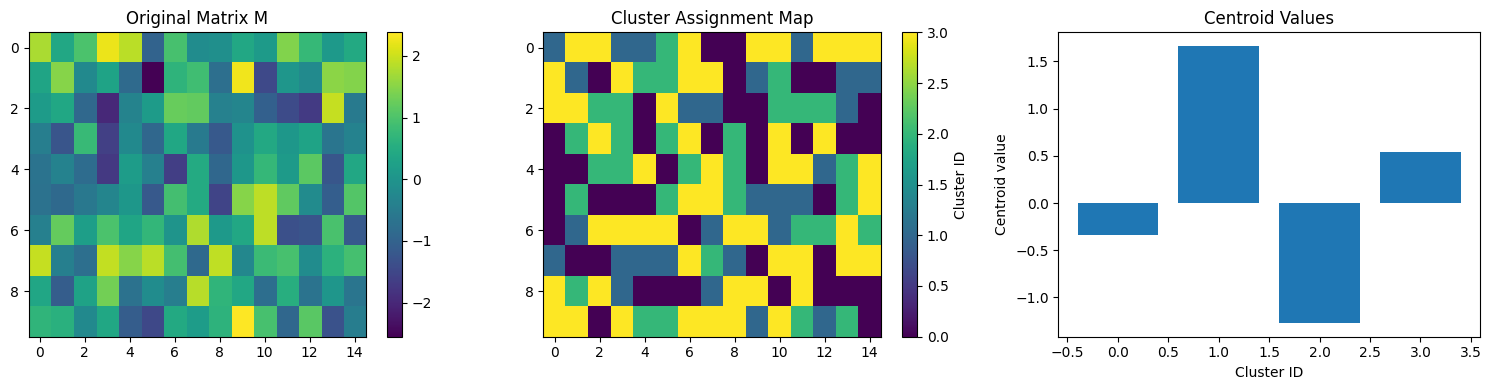

Centroids: [-0.34307208  1.66187019 -1.26918328  0.53622913]
Cluster sizes: {0: 41, 1: 27, 2: 31, 3: 51}


In [55]:
np.random.seed(0)
M = np.random.randn(10, 15)
k = 4

assignment_table, cookbook, centroids= kmeans_matrix(M, k)


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Original Matrix M")
plt.imshow(M, aspect="auto")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Cluster Assignment Map")
plt.imshow(assignment_table, aspect="auto")
plt.colorbar(label="Cluster ID")

plt.subplot(1, 3, 3)
plt.title("Centroid Values")
plt.bar(range(k), centroids)
plt.xlabel("Cluster ID")
plt.ylabel("Centroid value")

plt.tight_layout()
plt.show()

print("Centroids:", centroids)
print("Cluster sizes:", {c: len(cookbook[c]) for c in cookbook})


## Submission Guidelines
- Submit the completed `.ipynb` file.
- Clearly label all plots and outputs.
- Code readability and correctness matter.
- Partial credit will be given for logically correct implementations.

**Bonus**
- Compare convergence with and without standardization.
- Try different values of regularization strength.
